# AI image recognition challenge: NewFound vs Bear

### DATASET BALANCING:
Ensuring that there is no dataset imbalance. Each set is split into 60%, 20%, 20% for testing, validation and training respectively. 

In [14]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

def split_and_copy_equal_files(SOURCE, TRAINING, VALIDATION, TEST, total_count):
    # Load files
    files = [f for f in os.listdir(SOURCE) if os.path.getsize(os.path.join(SOURCE, f)) > 0]
    random.shuffle(files)
    
    if len(files) < total_count:
        raise ValueError(f"Not enough files in {SOURCE}. Required: {total_count}, Found: {len(files)}")

    # Calculate the split counts
    train_count = int(0.6 * total_count)  # 60% training
    valid_count = int(0.2 * total_count)  # 20% validation
    test_count = total_count - train_count - valid_count  # remaining for testing

    # Equal split
    train_files = files[:train_count]
    valid_files = files[train_count:train_count + valid_count]
    test_files = files[train_count + valid_count:train_count + valid_count + test_count]

    # Copy files to their respective directories
    for filename in train_files:
        shutil.copy2(os.path.join(SOURCE, filename), os.path.join(TRAINING, filename))
    for filename in valid_files:
        shutil.copy2(os.path.join(SOURCE, filename), os.path.join(VALIDATION, filename))
    for filename in test_files:
        shutil.copy2(os.path.join(SOURCE, filename), os.path.join(TEST, filename))

# Define the base directory 
base_dir = "./NewfoundlandvsBear"

# Define the categories (folder names)
categories = ["Bear", "Newfoundland"]

# Set equal split counts based on the minimum available in each dataset split
# Since "Bear" has fewer files, we'll use that as our baseline
min_total_count = min(192, 201)  # Smallest number of files available

# Create directory structure and split/copy files
for category in categories:
    SOURCE = os.path.join(base_dir, category)
    TRAINING = os.path.join(base_dir, "train", category)
    VALIDATION = os.path.join(base_dir, "validation", category)
    TEST = os.path.join(base_dir, "test", category)
    os.makedirs(TRAINING, exist_ok=True)
    os.makedirs(VALIDATION, exist_ok=True)
    os.makedirs(TEST, exist_ok=True)

    split_and_copy_equal_files(SOURCE, TRAINING, VALIDATION, TEST, min_total_count)

# Print the number of files in each set to verify
for category in categories:
    TRAINING = os.path.join(base_dir, "train", category)
    VALIDATION = os.path.join(base_dir, "validation", category)
    TEST = os.path.join(base_dir, "test", category)
    print(f"{category} - Training: {len(os.listdir(TRAINING))}, Validation: {len(os.listdir(VALIDATION))}, Testing: {len(os.listdir(TEST))}")

Bear - Training: 218, Validation: 200, Testing: 200
Newfoundland - Training: 201, Validation: 194, Testing: 197


### Installing and importing the neccessary packages:

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import sem, t
import matplotlib.pyplot as plt

### Image preprocessing and data augmentation:

In [16]:
# Set constants
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 15
NUM_CLASSES = 2  
seed_value = 42

# Data generators with augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255.0)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    './NewfoundlandvsBear/train',  
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    './NewfoundlandvsBear/validation',  
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    './NewfoundlandvsBear/test',  
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)




Found 417 images belonging to 2 classes.
Found 392 images belonging to 2 classes.
Found 395 images belonging to 2 classes.


### Data visualization:

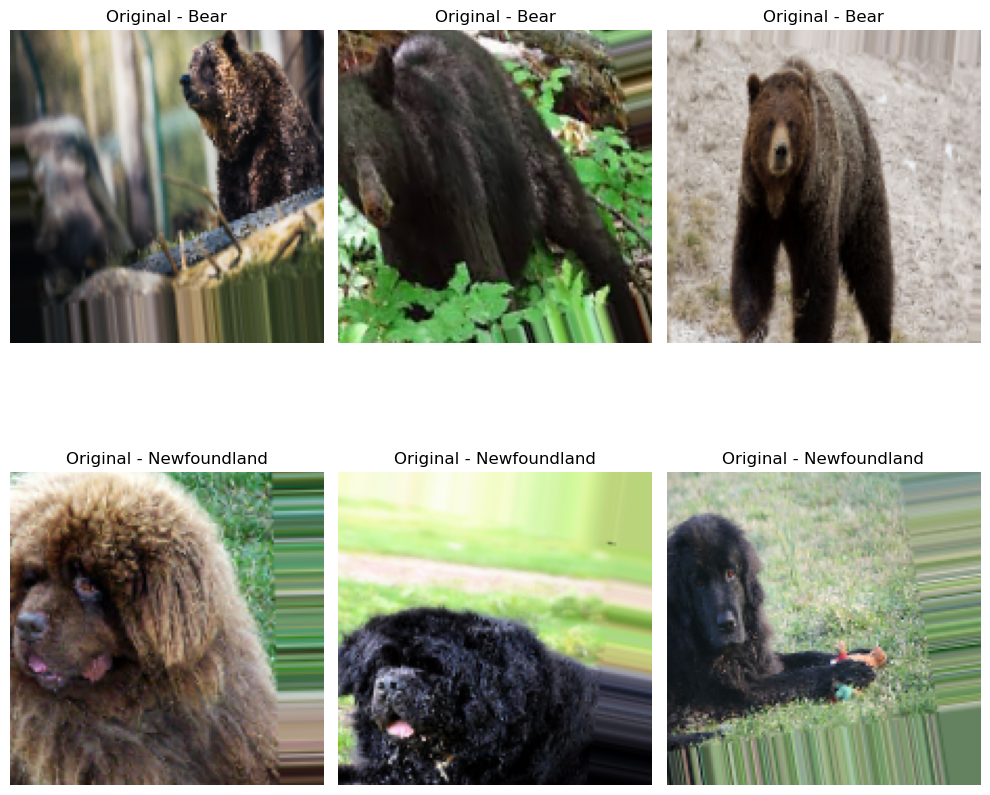

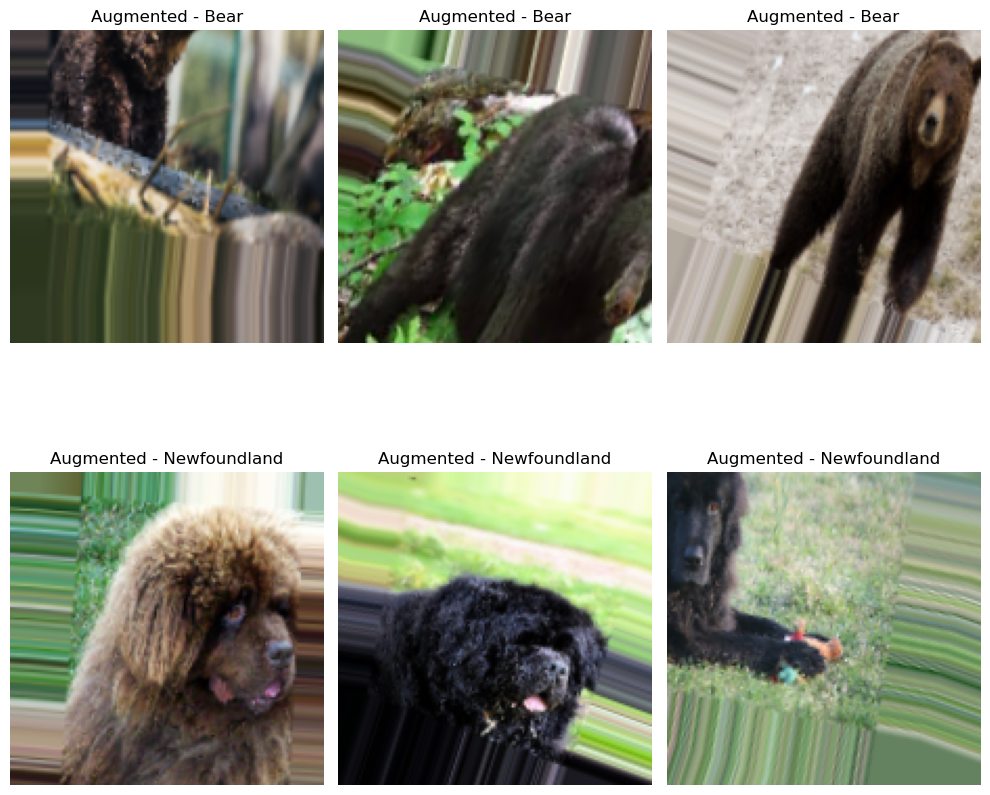

In [17]:
import numpy as np
import matplotlib.pyplot as plt



# Get class names
class_names = list(train_generator.class_indices.keys())

# Get a batch of images and labels
images, labels = next(train_generator)

# Augment the images using the same data generator
augmented_images = np.array([train_datagen.random_transform(image) for image in images])

# Number of samples to display per category
num_samples = 3
num_categories = len(class_names)

# Plot original images
plt.figure(figsize=(10, 10))

for i in range(num_categories):
    # Select images of the current category
    category_indices = np.argmax(labels, axis=1) == i
    category_samples = images[category_indices][:num_samples]
    
    # Plot each sample
    for j in range(num_samples):
        plt.subplot(num_categories, num_samples, i * num_samples + j + 1)
        plt.imshow(category_samples[j])
        plt.title(f"Original - {class_names[i]}")
        plt.axis("off")

plt.tight_layout()
plt.show()

# Plot augmented images
plt.figure(figsize=(10, 10))

for i in range(num_categories):
    # Select augmented images of the current category
    category_indices = np.argmax(labels, axis=1) == i
    category_augmented_samples = augmented_images[category_indices][:num_samples]

    # Plot each augmented sample
    for j in range(num_samples):
        plt.subplot(num_categories, num_samples, i * num_samples + j + 1)
        plt.imshow(category_augmented_samples[j])
        plt.title(f"Augmented - {class_names[i]}")
        plt.axis("off")

plt.tight_layout()
plt.show()


### Transfer learning and VGGI16 model:
A pre-trained VGG16 model is used with its layers frozen. The top layers are customized with a Flatten, Dense, Dropout, and output layer for classification

In [18]:
# Define the model using Transfer Learning
def build_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


### K-fold cross-validation:
5-fold cross-validation to train and evaluate the model on different splits of the data. Includes early stopping, learning rate reduction, and model checkpointing.

In [38]:
# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed_value)
acc_scores, prec_scores, rec_scores, f1_scores, auc_scores = [], [], [], [], []

for train_index, val_index in kf.split(train_generator):
    model = build_model()

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

    # Train the model
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=valid_generator,
        callbacks=[early_stopping, reduce_lr, checkpoint]
    )

    # Load the best model
    model.load_weights('best_model.keras')


Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.5045 - loss: 0.9479 - val_accuracy: 0.6250 - val_loss: 0.6220 - learning_rate: 1.0000e-04
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.6466 - loss: 0.6597 - val_accuracy: 0.8087 - val_loss: 0.3818 - learning_rate: 1.0000e-04
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.7101 - loss: 0.5266 - val_accuracy: 0.9005 - val_loss: 0.2823 - learning_rate: 1.0000e-04
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.7646 - loss: 0.5084 - val_accuracy: 0.9209 - val_loss: 0.2449 - learning_rate: 1.0000e-04
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.8549 - loss: 0.3597 - val_accuracy: 0.8801 - val_loss: 0.2925 - learning_rate: 1.0000e-04
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.8260 - loss: 0.3753 - val_accuracy: 0.9133 - val_loss: 0.2283 - learning_rate: 1.0000e-04
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.8328 - loss:

2024-08-15 19:28:53.795481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:311: Filling up shuffle buffer (this may take a while): 5 of 8
2024-08-15 19:28:55.120747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14/14 ━━━━━━━━━━━━━━━━━━━━ 1927s 75s/step - accuracy: 0.8376 - loss: 0.3809 - val_accuracy: 0.9209 - val_loss: 0.2313 - learning_rate: 1.0000e-04
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 1047s 80s/step - accuracy: 0.8239 - loss: 0.4176 - val_accuracy: 0.9209 - val_loss: 0.2288 - learning_rate: 1.0000e-04
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 990s 76s/step - accuracy: 0.8212 - loss: 0.3679 - val_accuracy: 0.9413 - val_loss: 0.1953 - learning_rate: 1.0000e-04
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 947s 72s/step - accuracy: 0.8616 - loss: 0.3281 - val_accuracy: 0.9490 - val_loss: 0.1798 - learning_rate: 1.0000e-04
Epoch 9/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 883s 68s/step - accuracy: 0.8799 - loss: 0.2643 - val_accuracy: 0.9515 - val_loss: 0.1672 - learning_rate: 1.0000e-04
Epoch 10/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8810 - loss: 0.3047 - val_accuracy: 0.9541 - val_loss: 0.1594 - learning_rate: 1.0000e-04
Epoch 11/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.8689 - lo

### Model training and evaluation:
Training: The model is trained with each fold using the training and validation generators.
Evaluation: After training, the model is evaluated on the test set, and metrics such as accuracy, precision, recall, F1 score, and AUC are calculated.

In [39]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")
   


13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9582 - loss: 0.1275
Test Accuracy: 0.95


Plotting: For each fold, the code plots the training and validation loss and accuracy over the epochs, providing a visual representation of how the model performed on each subset of the data.

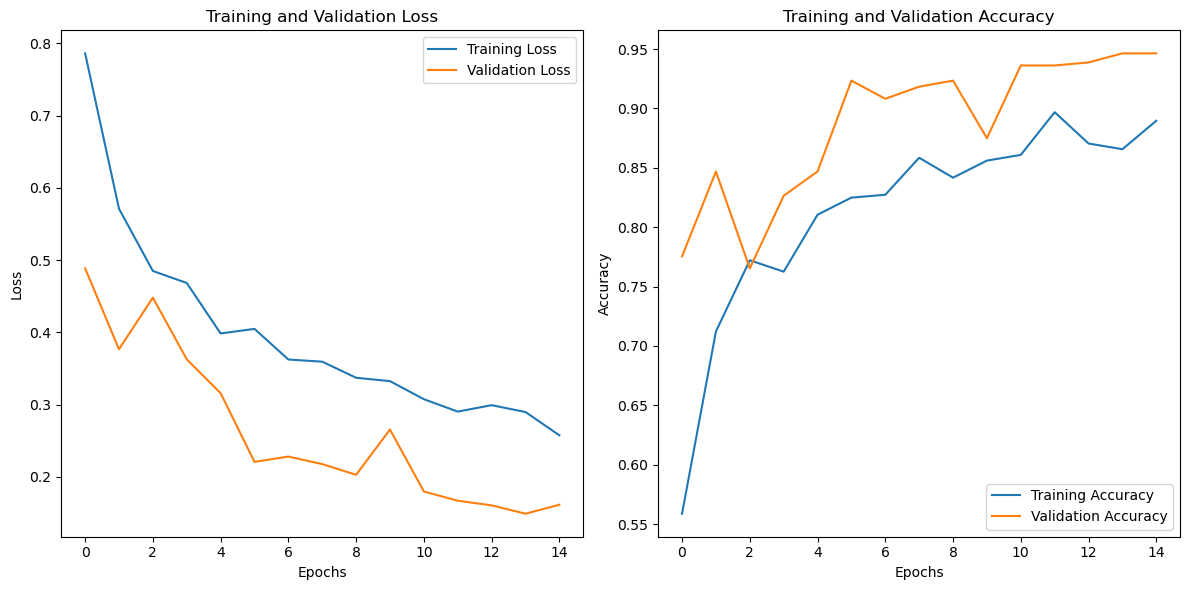

In [40]:
#Plot of training and validation loss and accuracy

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Confusion matrix:

13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step


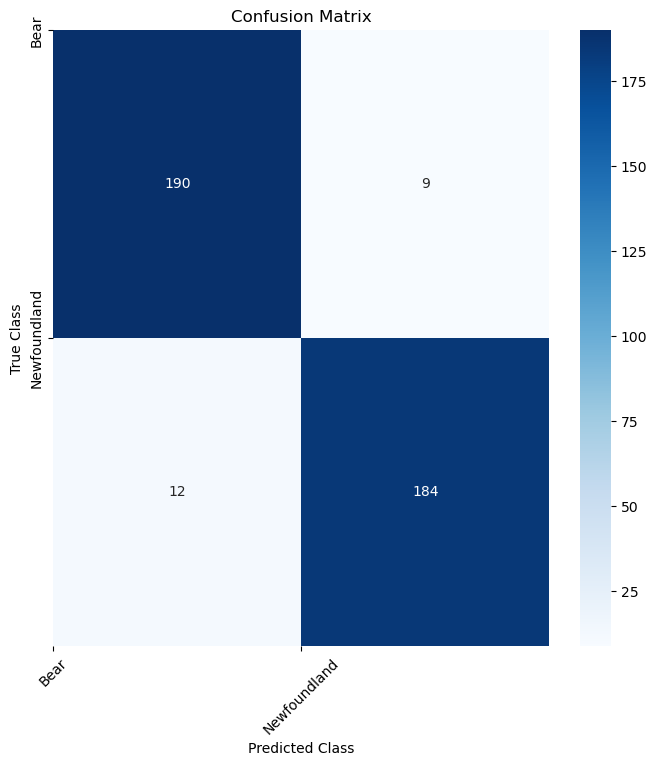

Classification Report:
              precision    recall  f1-score   support

        Bear       0.94      0.95      0.95       199
Newfoundland       0.95      0.94      0.95       196

    accuracy                           0.95       395
   macro avg       0.95      0.95      0.95       395
weighted avg       0.95      0.95      0.95       395



In [41]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the test dataset
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(test_generator.class_indices)), list(test_generator.class_indices.keys()), rotation=45)
plt.yticks(np.arange(len(test_generator.class_indices)), list(test_generator.class_indices.keys()))
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

## Sequential CNN:
### Defining the model:

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the Sequential CNN model
def build_sequential_cnn(input_shape=(150, 150, 3), num_classes=2):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build the CNN model
model = build_sequential_cnn()

# Data generators with augmentation for training and normalization for validation and testing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    './NewfoundlandvsBear/train',  
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    './NewfoundlandvsBear/validation',  
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    './NewfoundlandvsBear/test',  
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 417 images belonging to 2 classes.
Found 392 images belonging to 2 classes.
Found 395 images belonging to 2 classes.


/Users/bhavishyadurbha/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Training the model:

In [43]:
# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_sequential_cnn_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Load the best model
model.load_weights('best_sequential_cnn_model.keras')

Epoch 1/15


/Users/bhavishyadurbha/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 996ms/step - accuracy: 0.4893 - loss: 1.5443 - val_accuracy: 0.5077 - val_loss: 0.6837 - learning_rate: 0.0010
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 875ms/step - accuracy: 0.5133 - loss: 0.6918 - val_accuracy: 0.5077 - val_loss: 0.7214 - learning_rate: 0.0010
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 936ms/step - accuracy: 0.5467 - loss: 0.7059 - val_accuracy: 0.5816 - val_loss: 0.6452 - learning_rate: 0.0010
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 956ms/step - accuracy: 0.5617 - loss: 0.6641 - val_accuracy: 0.7245 - val_loss: 0.5865 - learning_rate: 0.0010
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 873ms/step - accuracy: 0.6962 - loss: 0.6179 - val_accuracy: 0.5918 - val_loss: 0.6646 - learning_rate: 0.0010
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 908ms/step - accuracy: 0.6196 - loss: 0.6309 - val_accuracy: 0.7347 - val_loss: 0.5823 - learning_rate: 0.0010
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 907ms/step - accuracy: 0.6776 - loss: 0.5973 - val_

In [44]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Generate predictions
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification report
target_names = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 407ms/step - accuracy: 0.7310 - loss: 0.5075
Test Accuracy: 0.76
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 407ms/step
Classification Report:
              precision    recall  f1-score   support

        Bear       0.84      0.65      0.74       199
Newfoundland       0.71      0.88      0.79       196

    accuracy                           0.76       395
   macro avg       0.78      0.77      0.76       395
weighted avg       0.78      0.76      0.76       395



### Confusion matrix:

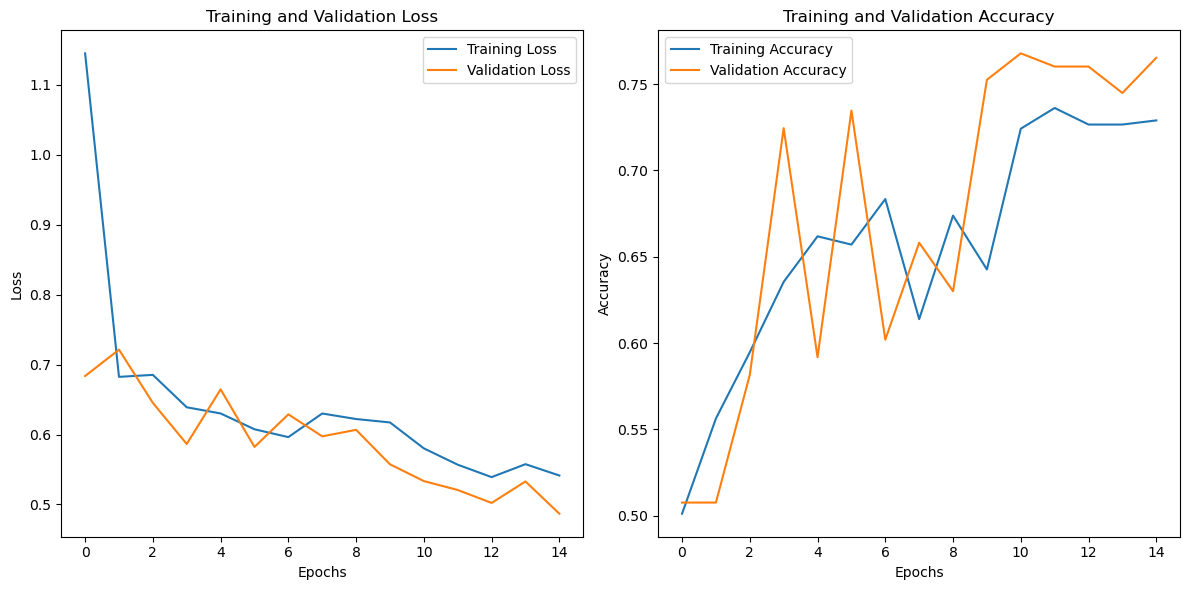

In [46]:
#Plot of training and validation loss and accuracy

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


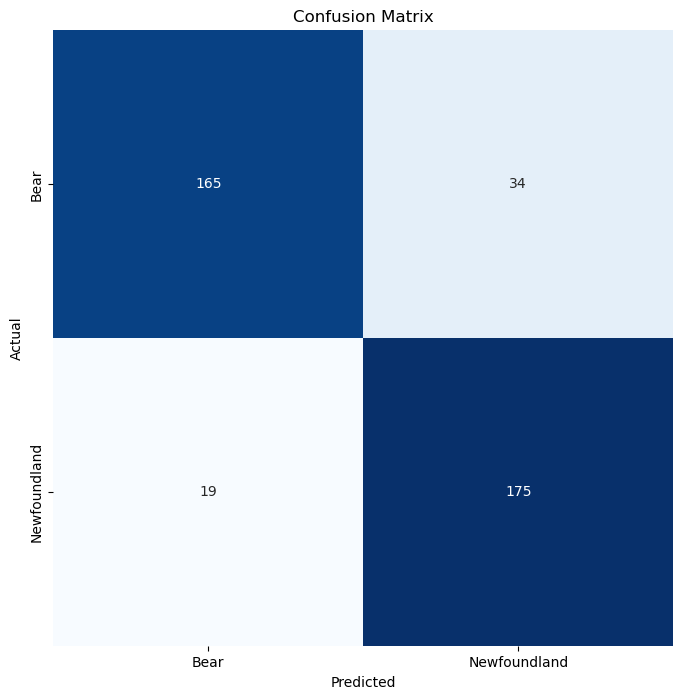

In [134]:
# Confusion Matrix Plot
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Binary classification using sequential CNN

In [47]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Load VGG16 model pre-trained on ImageNet, excluding the top layers
def build_vgg16_binary_classification_model(input_shape=(150, 150, 3)):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification
    
    model = Model(inputs=base_model.input, outputs=output)
    
    # Compile the model with custom metrics
    model.compile(
        optimizer="adam", 
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.Precision(name='precision'), 
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.TruePositives(name='tp'),
            tf.keras.metrics.TrueNegatives(name='tn'),
            tf.keras.metrics.FalsePositives(name='fp'),
            tf.keras.metrics.FalseNegatives(name='fn')
        ]
    )
    return model

# Build the model
model = build_vgg16_binary_classification_model()

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Paths to dataset
train_generator = train_datagen.flow_from_directory(
    './NewfoundlandvsBear/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    './NewfoundlandvsBear/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    './NewfoundlandvsBear/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)





Found 417 images belonging to 2 classes.
Found 392 images belonging to 2 classes.
Found 395 images belonging to 2 classes.


In [48]:
# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_vgg16_binary_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Load the best model
model.load_weights('best_vgg16_binary_model.keras')

Epoch 1/15


/Users/bhavishyadurbha/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - auc: 0.5141 - fn: 55.4000 - fp: 57.6667 - loss: 2.2802 - precision: 0.4529 - recall: 0.4655 - tn: 65.3333 - tp: 56.8667 - val_auc: 0.9351 - val_fn: 84.0000 - val_fp: 3.0000 - val_loss: 0.4779 - val_precision: 0.9732 - val_recall: 0.5648 - val_tn: 196.0000 - val_tp: 109.0000 - learning_rate: 0.0010
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - auc: 0.8003 - fn: 30.5333 - fp: 34.5333 - loss: 0.5751 - precision: 0.7109 - recall: 0.7144 - tn: 90.3333 - tp: 81.9333 - val_auc: 0.9700 - val_fn: 15.0000 - val_fp: 12.0000 - val_loss: 0.2463 - val_precision: 0.9368 - val_recall: 0.9223 - val_tn: 187.0000 - val_tp: 178.0000 - learning_rate: 0.0010
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - auc: 0.9148 - fn: 23.0667 - fp: 16.8000 - loss: 0.3592 - precision: 0.8493 - recall: 0.7987 - tn: 117.6667 - tp: 86.0000 - val_auc: 0.9777 - val_fn: 14.0000 - val_fp: 10.0000 - val_loss: 0.2050 - val_precision: 0.9471 - val_recall: 0.9275 - val_tn: 189.000

In [49]:
# Evaluate the model on the test data
evaluation_metrics = model.evaluate(test_generator)

# Print all the returned evaluation metrics
print(evaluation_metrics)

# Unpack the returned values based on the actual number of metrics returned

test_loss, precision, recall, auc, tp, tn, fp, fn = evaluation_metrics

# Print the metrics
print(f'Test Loss: {test_loss:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUC: {auc:.4f}')
print(f'True Positives: {tp}')
print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')






13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - auc: 0.5690 - fn: 1.1429 - fp: 6.0714 - loss: 0.0857 - precision: 0.5226 - recall: 0.5650 - tn: 155.6429 - tp: 71.8571      
[0.10153982788324356, 0.9599999785423279, 0.9795918464660645, 0.9937442541122437, 192.0, 191.0, 8.0, 4.0]
Test Loss: 0.1015
Precision: 0.9600
Recall: 0.9796
AUC: 0.9937
True Positives: 192.0
True Negatives: 191.0
False Positives: 8.0
False Negatives: 4.0


<Figure size 1200x600 with 0 Axes>

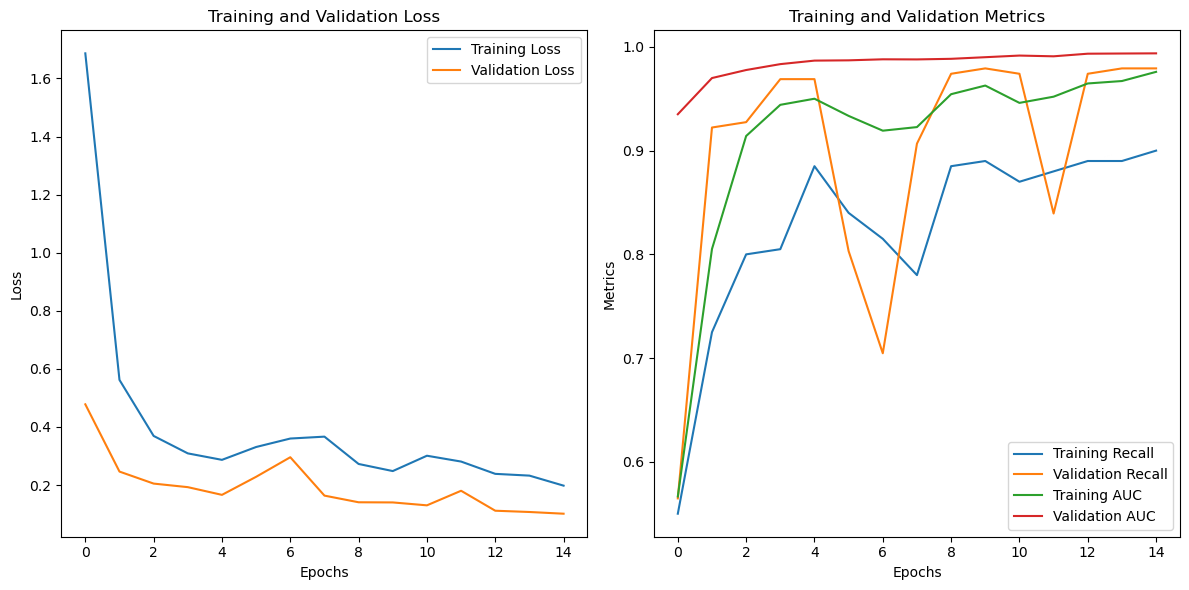

In [50]:
#Plot of training and validation loss and metrics
plt.figure(figsize=(12, 6))

# Plot training and validation metrics
# Extract the training history from the training log
training_loss = history.history['loss']
training_precision = history.history['precision']
training_recall = history.history['recall']
training_auc = history.history['auc']

# Extract the validation history from the training log
val_loss = history.history['val_loss']
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']
val_auc = history.history['val_auc']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()



# Plot training and validation metrics

plt.subplot(1, 2, 2)

plt.plot(training_recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.plot(training_auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics')
plt.legend()



plt.tight_layout()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step


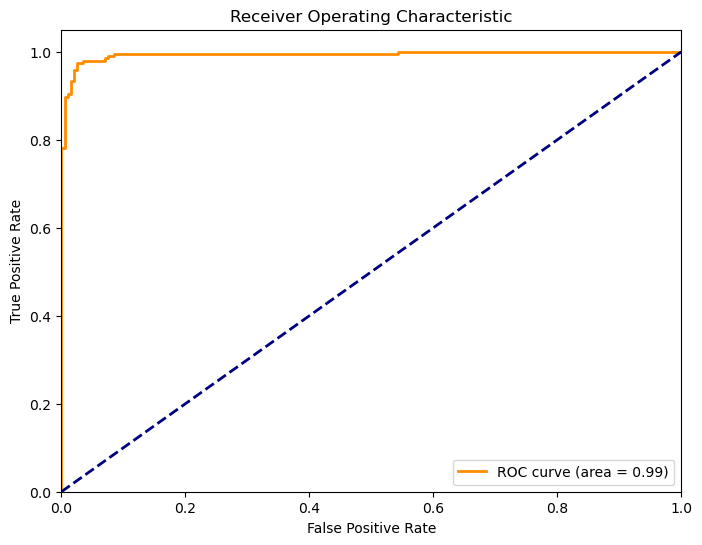

In [52]:
from sklearn.metrics import roc_curve, auc
# Generate predictions
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred_prob = y_pred_prob[:, 0]  # Use the probabilities of the positive class

# Generate the ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Resnet:

In [62]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def build_resnet_model(input_shape=(150, 150, 3), num_classes=2):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

    model = Model(inputs=base_model.input, outputs=output)
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=[
        'accuracy', 
        tf.keras.metrics.Precision(name='precision'), 
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ])
    return model

# Build the model
model = build_resnet_model()

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
checkpoint_path = "./best_resnet_model.keras"
valid_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    './NewfoundlandvsBear/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    './NewfoundlandvsBear/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    './NewfoundlandvsBear/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

  


Found 417 images belonging to 2 classes.
Found 392 images belonging to 2 classes.
Found 395 images belonging to 2 classes.


In [66]:
# Callbacks
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr])


model.load_weights(checkpoint_path)

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.4813 - auc: 0.4651 - loss: 0.7486 - precision: 0.4581 - recall: 0.4646 - val_accuracy: 0.5077 - val_auc: 0.6031 - val_loss: 0.6976 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5092 - auc: 0.5004 - loss: 0.7444 - precision: 0.4968 - recall: 0.2763 - val_accuracy: 0.5077 - val_auc: 0.6068 - val_loss: 0.6952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5071 - auc: 0.5475 - loss: 0.7157 - precision: 0.5117 - recall: 0.3519 - val_accuracy: 0.4923 - val_auc: 0.5968 - val_loss: 0.6995 - val_precision: 0.4923 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5205 - auc: 0.5637 - loss: 0.7139 - precision: 0.4787 - recall: 0.6724 - val_accuracy: 0.5179 - val_auc: 0.6185 - va

In [67]:
# Evaluate the model on the test dataset
evaluation_metrics = model.evaluate(test_generator)
print("Evaluation results:", evaluation_metrics)


test_loss, test_accuracy, test_auc, test_precision, test_recall = evaluation_metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 647ms/step - accuracy: 0.7341 - auc: 0.3494 - loss: 0.6714 - precision: 0.2695 - recall: 0.1606     
Evaluation results: [0.686825692653656, 0.5443037748336792, 0.5952380895614624, 0.2551020383834839, 0.6140908598899841]
Test Loss: 0.686825692653656
Test Accuracy: 0.5443037748336792
Test AUC: 0.5952380895614624
Test Precision: 0.2551020383834839
Test Recall: 0.6140908598899841


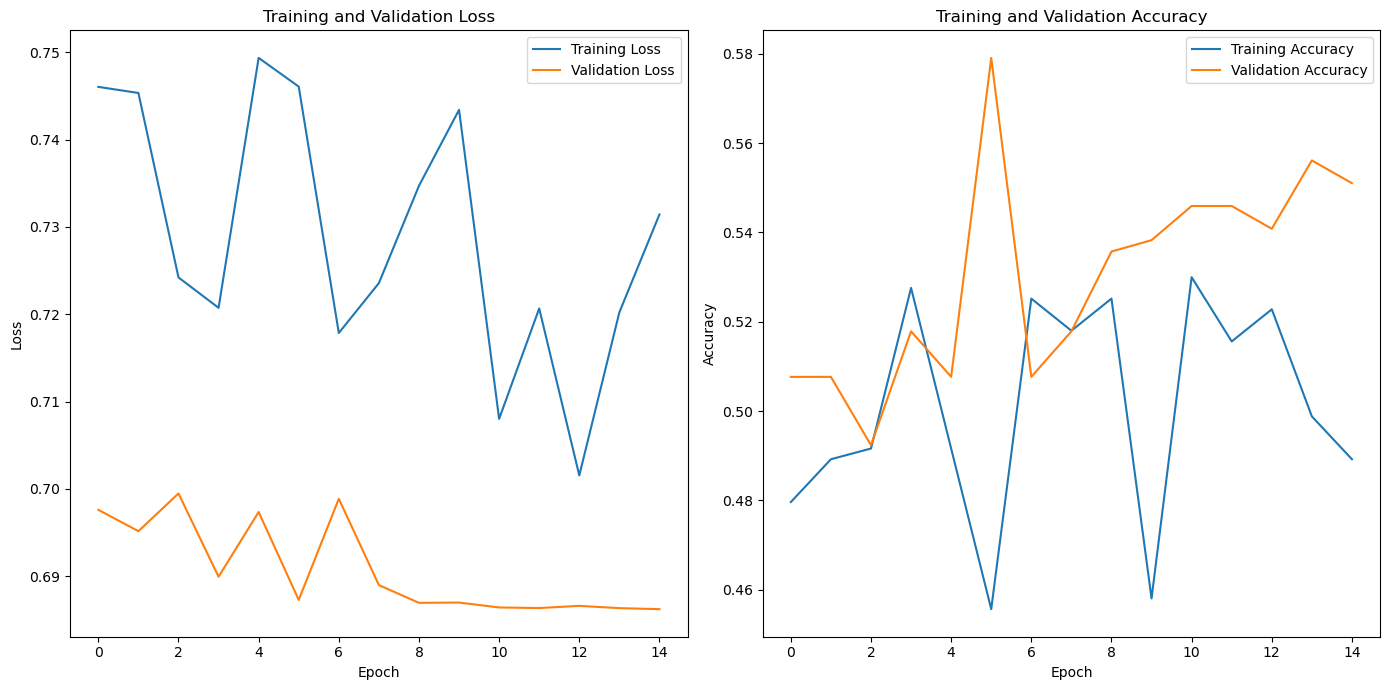

In [68]:
plt.figure(figsize=(14, 7))

# Subplot for the loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Subplot for the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 602ms/step


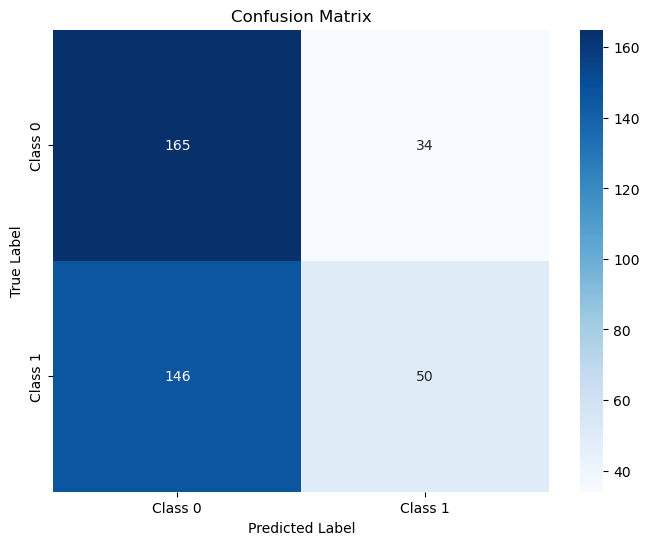

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.53      0.83      0.65       199
     Class 1       0.60      0.26      0.36       196

    accuracy                           0.54       395
   macro avg       0.56      0.54      0.50       395
weighted avg       0.56      0.54      0.50       395



In [72]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


y_pred_prob = model.predict(test_generator) 
y_pred = (y_pred_prob > 0.5).astype(int)  # Applying threshold to convert probabilities to binary labels


y_true = test_generator.classes  


conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0))



### Imbalanced dataset:

In [203]:
!pip install --upgrade tensorflow


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/0f/a5/89a9bdae9f241cad167edb6c890ef2b4c842c5ae81058a2fbfd702dba9bf/tensorflow-2.17.0-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Using cached tensorflow-2.17.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (4.1 kB)
  Obtaining dependency information for tensorboard<2.18,>=2.17 from https://files.pythonhosted.org/packages/0a/32/2e8545fb0592f33e3aca5951e8b01008b76d61b440658cbdc37b4eaebf0b/tensorboard-2.17.0-py3-none-any.whl.metadata
  Using cached tensorboard-2.17.0-py3-none-any.whl.metadata (1.6 kB)
Using cached tensorflow-2.17.0-cp311-cp311-macosx_12_0_arm64.whl (236.2 MB)
Using cached tensorboard-2.17.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Unin

In [94]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define the Sequential CNN model
def build_sequential_cnn(input_shape=(150, 150, 3), num_classes=2):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam', 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model

# Build the CNN model
model = build_sequential_cnn()

# Data generators
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
valid_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Load datasets 
train_generator = train_datagen.flow_from_directory(
    './NewfoundlandvsBear_imbalancedata/train',  
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    './NewfoundlandvsBear_imbalancedata/validation', 
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)



Found 216 images belonging to 2 classes.
Found 86 images belonging to 2 classes.


In [95]:
# Compute class weights
classes = np.unique(train_generator.classes)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_sequential_cnn_model.keras', monitor='val_loss', save_best_only=True)

# Train the model with class weights
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weights
)

# Load the best model
model.load_weights('best_sequential_cnn_model.keras')


Epoch 1/15


/Users/bhavishyadurbha/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 635ms/step - accuracy: 0.5551 - auc: 0.5308 - loss: 2.2754 - precision: 0.5551 - recall: 0.5551 - val_accuracy: 0.5465 - val_auc: 0.6098 - val_loss: 0.6902 - val_precision: 0.5465 - val_recall: 0.5465 - learning_rate: 0.0010
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 517ms/step - accuracy: 0.4538 - auc: 0.4429 - loss: 0.7144 - precision: 0.4538 - recall: 0.4538 - val_accuracy: 0.5465 - val_auc: 0.6274 - val_loss: 0.6870 - val_precision: 0.5465 - val_recall: 0.5465 - learning_rate: 0.0010
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 547ms/step - accuracy: 0.5262 - auc: 0.5622 - loss: 0.6885 - precision: 0.5262 - recall: 0.5262 - val_accuracy: 0.7442 - val_auc: 0.8241 - val_loss: 0.6411 - val_precision: 0.7442 - val_recall: 0.7442 - learning_rate: 0.0010
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 494ms/step - accuracy: 0.6717 - auc: 0.7155 - loss: 0.6282 - precision: 0.6717 - recall: 0.6717 - val_accuracy: 0.6163 - val_auc: 0.6846 - val_loss: 0.6430 - val_precision: 0.6163 

In [105]:
import numpy as np


predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Calculate accuracy 
correct_counts = np.sum(predicted_classes == true_classes)
total_samples = true_classes.shape[0]
accuracy = correct_counts / total_samples

print(f"Accuracy: {accuracy:.4f}")






/Users/bhavishyadurbha/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/stepWARNING:tensorflow:6 out of the last 18 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x32de9d580> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step
Accuracy: 0.7528


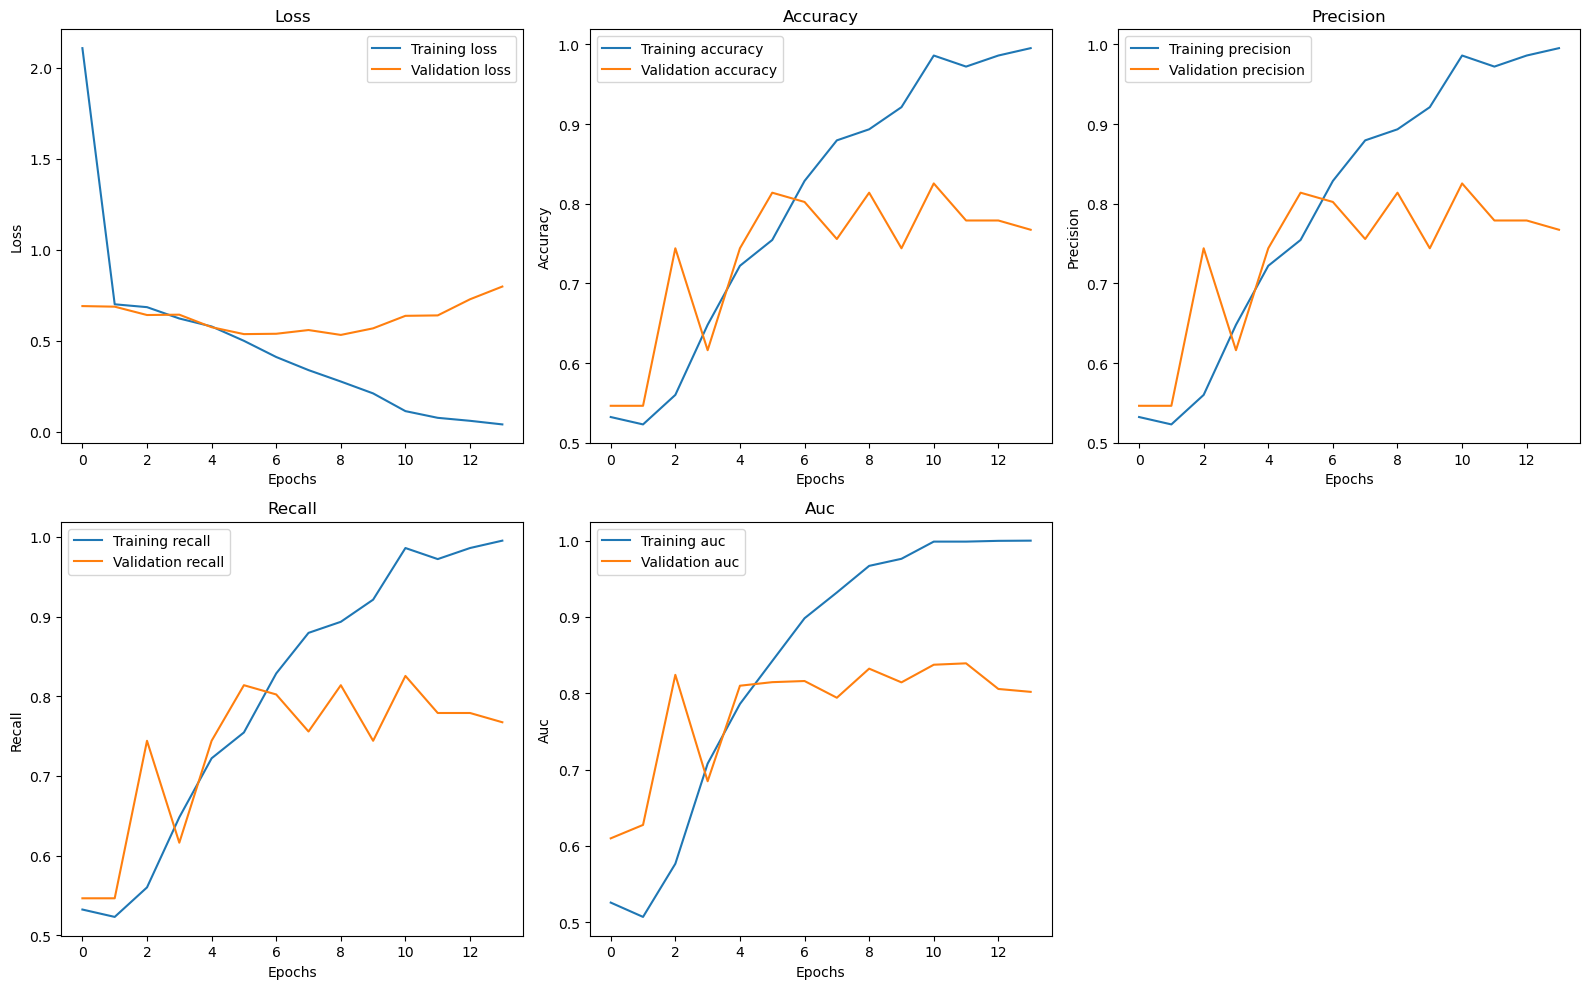

In [106]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
    plt.figure(figsize=(16, 10))
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'{metric.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        
    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_metrics(history)

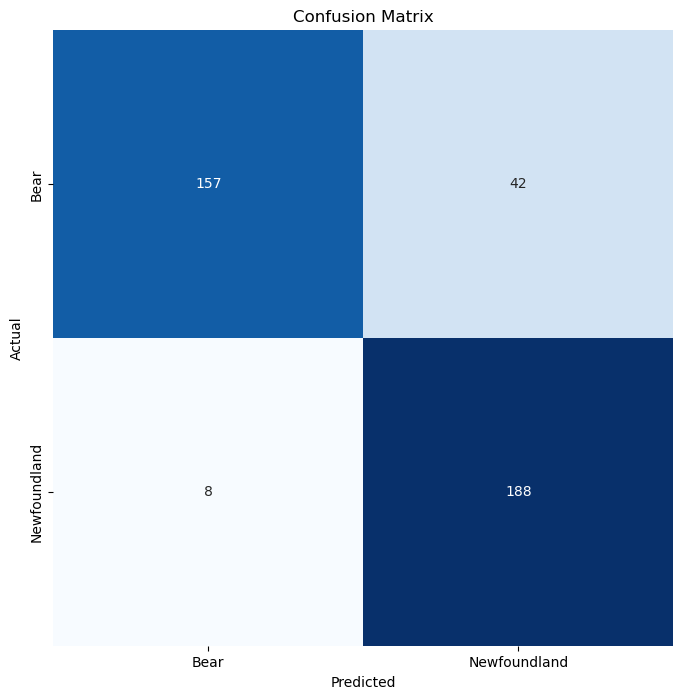

In [107]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

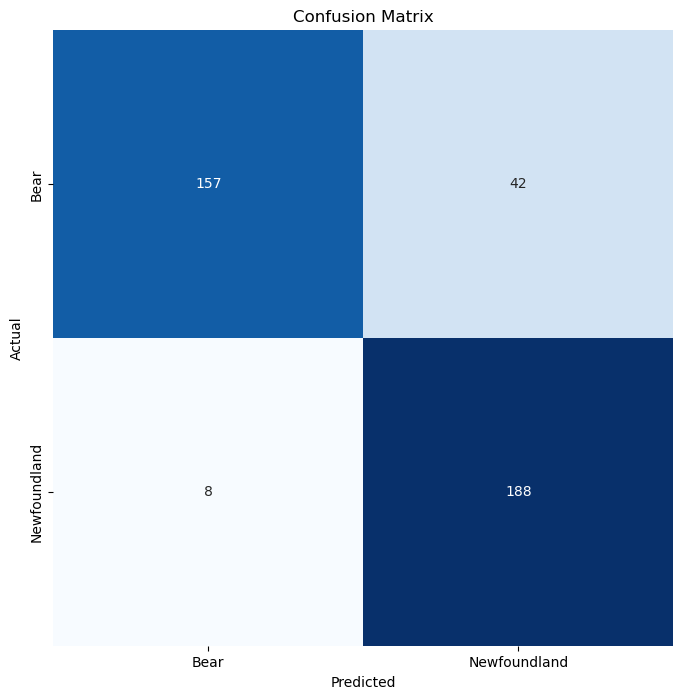

In [101]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()